# Correlated Dust and Synchrotron
In this example we show how to use the models and reproduce Fig. 7 of Planck18 XI

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pysm
import numpy as np
import matplotlib.pyplot as plt

We will create directly the frequency-frequency cross-spectrum, so we only need the `cross` module

In [3]:
import fgspectra.cross as fgc

## Parameters

The Planck and WMAP polarized channels involved are

In [4]:
nu = np.array([23, 28.4, 33, 100, 143, 217, 353])

From the paper (and in particular the legend of Fig 8) we get the following parameters

In [5]:
dust_params = dict(nu=nu, beta=1.5, temp=19.6, nu_0=353.0)
sync_params = dict(nu=nu, beta=-3.15, nu_0=30)
frequency_params = dict(kwseq=(dust_params, sync_params))

power_params = dict(
    ell=np.array([9, 50.0]),
    alpha=np.array([-2.51, -3.0]) + 2,  # +2 to (almost) get D_ell
    ell_0=50,
    amp=np.array([137.0, 0.6]),
    rho=0.17,
)

## Computing the cross-spectrum

We now create the appropriate object

In [6]:
dust_sync = fgc.CorrelatedDustSynchrotron()

and evaluate it for the parameters above

In [7]:
cl = dust_sync(frequency_params, power_params)

The output array has three dimensions: the first frequency, the second frequency and the multipoles

In [8]:
cl.shape

(7, 7, 2)

# Compare with Planck18 XI

We plot the cross-spectra at the effective frequency, defined as the geometric mean of the two frequencies involved

In [9]:
nu_eff = (nu * nu[:, np.newaxis]) ** 0.5

and here are the plots

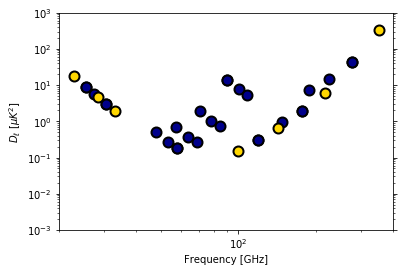

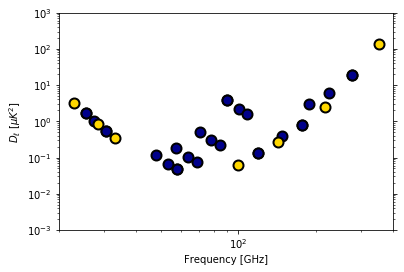

In [10]:
for b in range(2):
    plt.figure()
    for i in range(len(nu)):
        for j in range(i - 1, len(nu)):
            if i == j:
                color = "Gold"
            else:
                color = "DarkBlue"
            plt.loglog(
                nu_eff[i, j],
                cl[i, j, b],
                "o",
                c=color,
                markeredgewidth=2.0,
                markeredgecolor="k",
                markersize=10,
            )
    plt.gca().yaxis.set_ticks_position("both")
    plt.ylim(1e-3, 1e3)
    plt.xlim(20, 400)
    plt.ylabel("$D_\\ell\ [ \mu K^2]$")
    plt.xlabel("Frequency [GHz]")
None

## Juggling  with `Model` objects
In `fgspectra` any SED, power spectrum or cross-spectrum is a `Model`. You can print them to have an idea of what is inside. For example,

In [11]:
dust_sync

CorrelatedDustSynchrotron:
- Join (SED):
  - ModifiedBlackBody: {beta: null, nu: null, nu_0: null, temp: null}
  - PowerLaw: {beta: null, nu: null, nu_0: null}
- CorrelatedPowerLaws (Cl): {alpha: null, amp: null, ell: null, ell_0: null, rho: null}

shows that the frequency dependence of `dust_sync` joins two components: a modified-black body (dust) and a power law (synchrotron). The power spectrum is specified by a set of correlated power laws. In addition, also the default values of the parameters are displayed. You can change them anytime, in the same way you would evaluate the model. For example, if you want to fix the parameters of the power spectrum part of the cross-spectrum,

In [12]:
dust_sync.set_defaults(cl_kwargs=power_params)

In [13]:
dust_sync

CorrelatedDustSynchrotron:
- Join (SED):
  - ModifiedBlackBody: {beta: null, nu: null, nu_0: null, temp: null}
  - PowerLaw: {beta: null, nu: null, nu_0: null}
- CorrelatedPowerLaws (Cl):
    alpha: [-0.5099999999999998, -1.0]
    amp: [137.0, 0.6]
    ell: [9.0, 50.0]
    ell_0: 50
    rho: 0.17

Now when you evaluate the model you can pass only the remaining arguments

In [14]:
cl2 = dust_sync(sed_kwargs=frequency_params)
np.all(cl == cl2)

True

Yet another way to specify defaults is at construction time

In [15]:
dust_sync2 = fgc.CorrelatedDustSynchrotron(
    sed_kwargs=frequency_params, cl_kwargs=power_params
)
dust_sync2

CorrelatedDustSynchrotron:
- Join (SED):
  - ModifiedBlackBody:
      beta: 1.5
      nu: [23.0, 28.4, 33.0, 100.0, 143.0, 217.0, 353.0]
      nu_0: 353.0
      temp: 19.6
  - PowerLaw:
      beta: -3.15
      nu: [23.0, 28.4, 33.0, 100.0, 143.0, 217.0, 353.0]
      nu_0: 30
- CorrelatedPowerLaws (Cl):
    alpha: [-0.5099999999999998, -1.0]
    amp: [137.0, 0.6]
    ell: [9.0, 50.0]
    ell_0: 50
    rho: 0.17

In this case all the parameters are specified from the beginning, so we don't need any argument when we evaluate the model

In [16]:
cl3 = dust_sync2()
np.all(cl == cl3)

True

Note that you have complete freedom on which parameters you set to a default. For example, suppose we want to fix the frequencies for all the components.

In [17]:
dust_params = dict(nu=nu, nu_0=353.0)
sync_params = dict(nu=nu, nu_0=30)
frequency_params = dict(kwseq=(dust_params, sync_params))

In [18]:
fgc.CorrelatedDustSynchrotron(sed_kwargs=frequency_params)

CorrelatedDustSynchrotron:
- Join (SED):
  - ModifiedBlackBody:
      beta: null
      nu: [23.0, 28.4, 33.0, 100.0, 143.0, 217.0, 353.0]
      nu_0: 353.0
      temp: null
  - PowerLaw:
      beta: null
      nu: [23.0, 28.4, 33.0, 100.0, 143.0, 217.0, 353.0]
      nu_0: 30
- CorrelatedPowerLaws (Cl): {alpha: null, amp: null, ell: null, ell_0: null, rho: null}

In reality you typically want to sum the contribution of several uncorrelated components to get the total power on the sky.

In [29]:
total_cross = fgc.Sum(fgc.SZxCIB(), dust_sync)

The default assignment mechanism, as well as the object inspection works exactly in exactly the same way.

In [36]:
total_cross

Sum:
- SZxCIB:
  - Join (SED):
    - ThermalSZ: {nu: null, nu_0: null}
    - CIB: {beta: null, nu: null, nu_0: null, temp: null}
  - SZxCIB_Addison2012 (Cl):
    - PowerSpectrumFromFile: {amp: 1.0, ell: null, ell_0: null}
    - PowerLaw: {alpha: null, amp: 1.0, ell: null, ell_0: null}
    - PowerSpectrumFromFile: {amp: 1.0, ell: null, ell_0: null}
- CorrelatedDustSynchrotron:
  - Join (SED):
    - ModifiedBlackBody: {beta: null, nu: null, nu_0: null, temp: null}
    - PowerLaw: {beta: null, nu: null, nu_0: null}
  - CorrelatedPowerLaws (Cl):
      alpha: [-0.5099999999999998, -1.0]
      amp: [137.0, 0.6]
      ell: [9.0, 50.0]
      ell_0: 50
      rho: 0.17

Of course, if plug only one cross in, the result you get is the same you get without using the sum

In [35]:
np.all(fgc.Sum(dust_sync2)() == dust_sync2())

True